## Transfer learning, Dropout
* pre-trained model : Inception mode

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nEnough accuracy so cancel training!")
      self.model.stop_training=True

### Download pre-trained model

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-01-25 11:54:11--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.240, 172.217.13.240, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   130MB/s    in 0.6s    

2021-01-25 11:54:12 (130 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
# Import the Inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
# Create an instance of the inception model from the local pre-trained model
path_inception = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
local_weights_file = path_inception

### Pre-trained model의 weight를 이용하여 instantiate
중요한 것!! `Include_top=False`!!!
* input_shape은 ImageDataGenerator의 target_size와 맞추기

In [6]:
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)
pre_trained_model.load_weights(local_weights_file)

### Freeze model layers
* `trainable=False` 설정!!!

In [7]:
for layer in pre_trained_model.layers:
  layer.trainable = False

### 마지막 레이어 찾아서 내 모델 형태랑 맞추기
1. last layer 찾기
2. DNN 구조 추가하기 -> binary classification
3. Dropouts 추가

In [8]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

참고로 concatenate는 *사슬같이 잇다*라는 뜻이라 함. Fully-connected layer랑 같은 뜻이라 보면 될 것 같다.
* 근데 왜 last layer가 mixed7인지는 아직도 모르겠음...
* `.output_shape`을 하는 이유는 문제 조건 중 last layer의 shape이 (None, 7, 7, 768)이라고 나와서임.

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 7, 7, 768)


In [10]:
last_output = last_layer.output

In [11]:
# 모델 구조!!!
x = layers.Flatten()(last_output) # 찾은 last layer의 output 형태에 맞게 Flatten
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x) # pre-trained model이랑 내 DNN 모델이랑 합치기(?)

In [12]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

mixed7 후 Flatten, dropout 등이 잘 들어갔따.

### 이제 모델이 잘 만들어졌으니 이 모델로 Classification 진행
* ImageDataGenerator
* Augmentation
* Validation directory

In [14]:
import os
import zipfile

In [15]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2021-01-25 11:54:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.217.15.112, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   209MB/s    in 0.3s    

2021-01-25 11:54:28 (209 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [16]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [17]:
base_dir = '/tmp/cats_and_dogs_filtered' # 방금 압축해제하고 생긴 폴더
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [18]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [19]:
train_cat_filenames = os.listdir(train_cats_dir)
train_dog_filenames = os.listdir(train_dogs_dir)
print(len(train_cat_filenames), len(train_dog_filenames))

1000 1000


In [20]:
# ImageDataGenerator with Augmentaion
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    target_size=(150,150),
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150,150),
                                                              batch_size=20,
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
callbacks = myCallback()

history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100, # train_data size = batch * steps_per_epoch
                              validation_steps=50, # validation data size = batch * validation_steps
                              epochs=20,
                              verbose=2,
                              callbacks=[callbacks])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 - 28s - loss: 1.2945 - accuracy: 0.8335 - val_loss: 0.1176 - val_accuracy: 0.9510
Epoch 2/20
100/100 - 17s - loss: 0.3693 - accuracy: 0.8930 - val_loss: 0.3409 - val_accuracy: 0.9140
Epoch 3/20
100/100 - 18s - loss: 0.3094 - accuracy: 0.9055 - val_loss: 0.3539 - val_accuracy: 0.9120
Epoch 4/20
100/100 - 18s - loss: 0.3190 - accuracy: 0.9130 - val_loss: 0.2852 - val_accuracy: 0.9270
Epoch 5/20
100/100 - 17s - loss: 0.2894 - accuracy: 0.9115 - val_loss: 0.1196 - val_accuracy: 0.9670
Epoch 6/20
100/100 - 17s - loss: 0.2779 - accuracy: 0.9190 - val_loss: 0.1397 - val_accuracy: 0.9620
Epoch 7/20
100/100 - 18s - loss: 0.2232 - accuracy: 0.9295 - val_loss: 0.1558 - val_accuracy: 0.9560
Epoch 8/20
100/100 - 17s - loss: 0.2416 - accuracy: 0.9225 - val_loss: 0.1337 - val_accuracy: 0.9620
Epoch 9/20
100/100 - 17s - loss: 0.2053 - accuracy: 0.9395 - val_loss: 0.1626 - val_accuracy: 0.9620
Epoch 10/20
100/100 - 17s - loss: 0.2198 - accuracy: 0.9270 - val_loss: 0.1463 - val_accura

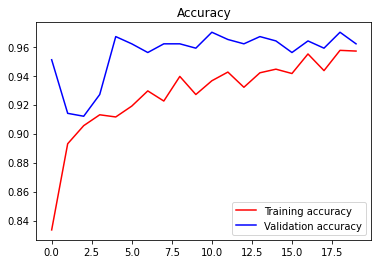

<Figure size 432x288 with 0 Axes>

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()